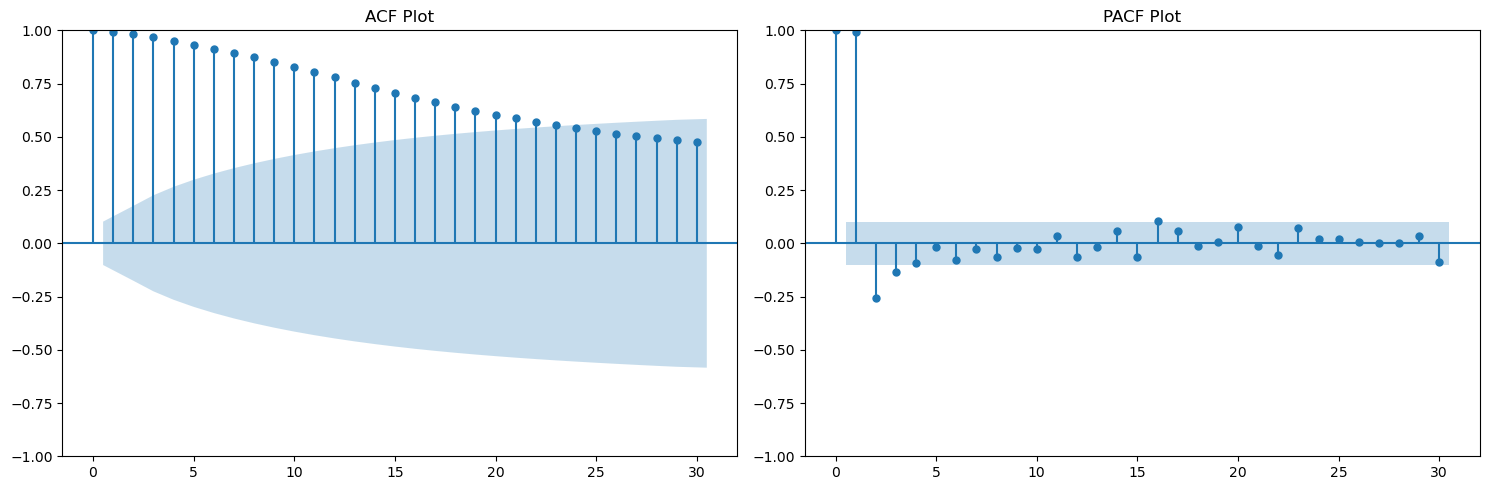

X_train shape: (285, 12, 1), y_train shape: (285, 3)
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1423 - val_loss: 0.0461
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0229 - val_loss: 0.0151
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0144 - val_loss: 0.0059
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - val_loss: 0.0013
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - val_loss: 0.0013
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - val_loss: 9.3834e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0058 - val_loss: 8.6217e-04
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - val_loss: 5.7020e-04
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 6.3694e-04
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0056 - val_loss: 4.2841e-04
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - val_loss: 3.8109e

In [1]:
#Long Short-Term Memory Model

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

random.seed(42)

new_directory = 'C:/Users/artem/Desktop'

os.chdir(new_directory)

euribor_data = pd.read_csv('ECB Data Portal_20241114135109.csv')

euribor_data.rename(columns={'Euribor 1-year - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR1YD_.HSTA)': 'Euribor'}, inplace=True)

columns_to_remove = ['DATE', 'TIME PERIOD']

euribor_data = euribor_data.drop(columns=columns_to_remove)

dates = pd.date_range(start='1994', periods=len(euribor_data), freq='M')

euribor_data.index = dates 

def acf_pacf_fig(series, both=True, lag=30):
    fig, axes = plt.subplots(1, 2 if both else 1, figsize=(15, 5))
    
    if both:
        plot_acf(series, lags=lag, ax=axes[0])
        plot_pacf(series, lags=lag, ax=axes[1])
        axes[0].set_title('ACF Plot')
        axes[1].set_title('PACF Plot')
    else:
        plot_acf(series, lags=lag, ax=axes[0])
        axes[0].set_title('ACF Plot')
    
    plt.tight_layout() 
    plt.show()

acf_pacf_fig(euribor_data['Euribor'], both=True, lag=30)

train = euribor_data.iloc[:300]  
valid_start = euribor_data.index[300]  
test_start = euribor_data.index[324]   

valid = euribor_data[(euribor_data.index >= valid_start) & (euribor_data.index < test_start)]
test = euribor_data[test_start:]

scaler = MinMaxScaler()
train.loc[:, 'Euribor'] = scaler.fit_transform(train[['Euribor']])
valid.loc[:, 'Euribor'] = scaler.transform(valid[['Euribor']])
test.loc[:, 'Euribor'] = scaler.transform(test[['Euribor']])

T = 12
HORIZON = 3  

def prepare_shifted_data(data, T, horizon):
    data_shifted = data.copy()

    y_columns = []
    for h in range(1, horizon + 1):
        data_shifted[f'y_t+{h}'] = data_shifted['Euribor'].shift(-h)
        y_columns.append(f'y_t+{h}')
    
    for t in range(1, T + 1):
        data_shifted[f'Euribor_t-{t}'] = data_shifted['Euribor'].shift(t)

    data_shifted.dropna(inplace=True)

    y = np.array(data_shifted[y_columns])
    X = np.array(data_shifted[[f'Euribor_t-{t}' for t in range(1, T + 1)]])

    return X.reshape(X.shape[0], T, 1), y

X_train, y_train = prepare_shifted_data(train, T, HORIZON)
X_valid, y_valid = prepare_shifted_data(valid, T, HORIZON)
X_test, y_test = prepare_shifted_data(test, T, HORIZON)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

latent_dim = 6
batch_size = 16
epochs = 50

model = Sequential()

model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

model.add(LSTM(latent_dim, return_sequences=True))

model.add(LSTM(units=64, return_sequences=False))

model.add(Dense(HORIZON))

model.compile(optimizer='adam', loss='mean_squared_error')

LSTM_earlystop = EarlyStopping(monitor='val_loss', patience=5)

model_fit = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[LSTM_earlystop],
    verbose=1
)

preds = model.predict(X_test)

evdta = pd.DataFrame(preds, columns=[f't+{t}' for t in range(1, 4)])  

predicted_values = evdta[['t+1', 't+2', 't+3']].values  
scaled_predicted_values = scaler.inverse_transform(predicted_values)

evdta[['t+1', 't+2', 't+3']] = scaled_predicted_values

evdta['Average Prediction'] = evdta[['t+1', 't+2', 't+3']].mean(axis=1)

evdta.columns = [f'November 2024' if col == 't+1' else 
                 f'December 2024' if col == 't+2' else
                 f'January 2025' if col == 't+3' else
                 'Average Prediction' if col == 'Average Prediction' else col
                 for col in evdta.columns]

evdta = evdta.drop(columns=['actual'], errors='ignore')

print(evdta[['November 2024', 'December 2024', 'January 2025', 'Average Prediction']])

y_test_flattened = y_test.reshape(-1, 1)

avg_nov_2024 = evdta['November 2024'].mean()
avg_dec_2024 = evdta['December 2024'].mean()
avg_jan_2025 = evdta['January 2025'].mean()

print(f"Average Prediction for November 2024 (t+1): {avg_nov_2024}")
print(f"Average Prediction for December 2024 (t+2): {avg_dec_2024}")
print(f"Average Prediction for January 2025 (t+3): {avg_jan_2025}")

mse_avg = mean_squared_error(y_test_flattened[:len(evdta)], evdta['Average Prediction'])
mse_t1 = mean_squared_error(y_test_flattened[:len(evdta)], evdta['November 2024'])
mse_t2 = mean_squared_error(y_test_flattened[:len(evdta)], evdta['December 2024'])
mse_t3 = mean_squared_error(y_test_flattened[:len(evdta)], evdta['January 2025'])

rmse_avg = np.sqrt(mse_avg)
rmse_t1 = np.sqrt(mse_t1)
rmse_t2 = np.sqrt(mse_t2)
rmse_t3 = np.sqrt(mse_t3)

print(f"Root Mean Squared Error for November 2024 (t+1): {rmse_t1}")
print(f"Root Mean Squared Error for December 2024 (t+2): {rmse_t2}")
print(f"Root Mean Squared Error for January 2025 (t+3): {rmse_t3}")
print(f"Root Mean Squared Error for Average Prediction: {rmse_avg}")

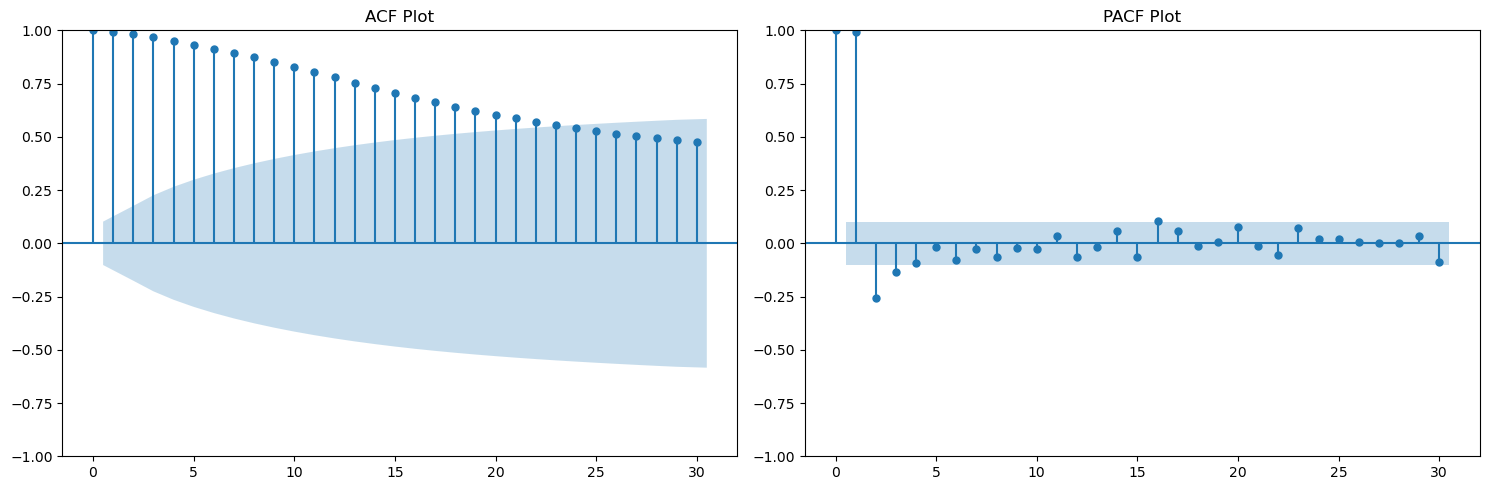

X_train shape: (285, 12, 1), y_train shape: (285, 3)
Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.1394 - val_loss: 0.0382
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0229 - val_loss: 0.0187
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0146 - val_loss: 0.0078
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0124 - val_loss: 0.0013
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - val_loss: 3.6294e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 3.0588e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109 - val_loss: 6.6394e-04
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - val_loss: 4.2341e-04
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089 - val_loss: 3.3639e-04
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 8.0440e-04
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - val_loss: 4.6

In [2]:
#Gated Recurrent Units Model

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

random.seed(42)

new_directory = 'C:/Users/artem/Desktop'

os.chdir(new_directory)

euribor_data = pd.read_csv('ECB Data Portal_20241114135109.csv')

euribor_data.rename(columns={'Euribor 1-year - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR1YD_.HSTA)': 'Euribor'}, inplace=True)

columns_to_remove = ['DATE', 'TIME PERIOD']

euribor_data = euribor_data.drop(columns=columns_to_remove)

dates = pd.date_range(start='1994', periods=len(euribor_data), freq='M')

euribor_data.index = dates 

def acf_pacf_fig(series, both=True, lag=30):
    fig, axes = plt.subplots(1, 2 if both else 1, figsize=(15, 5))
    
    if both:
        plot_acf(series, lags=lag, ax=axes[0])
        plot_pacf(series, lags=lag, ax=axes[1])
        axes[0].set_title('ACF Plot')
        axes[1].set_title('PACF Plot')
    else:
        plot_acf(series, lags=lag, ax=axes[0])
        axes[0].set_title('ACF Plot')
    
    plt.tight_layout() 
    plt.show()

acf_pacf_fig(euribor_data['Euribor'], both=True, lag=30)

train = euribor_data.iloc[:300]  
valid_start = euribor_data.index[300]  
test_start = euribor_data.index[324]   

valid = euribor_data[(euribor_data.index >= valid_start) & (euribor_data.index < test_start)]
test = euribor_data[test_start:]

scaler = MinMaxScaler()
train.loc[:, 'Euribor'] = scaler.fit_transform(train[['Euribor']])
valid.loc[:, 'Euribor'] = scaler.transform(valid[['Euribor']])
test.loc[:, 'Euribor'] = scaler.transform(test[['Euribor']])

T = 12
HORIZON = 3  

def prepare_shifted_data(data, T, horizon):
    data_shifted = data.copy()

    y_columns = []
    for h in range(1, horizon + 1):
        data_shifted[f'y_t+{h}'] = data_shifted['Euribor'].shift(-h)
        y_columns.append(f'y_t+{h}')
    
    for t in range(1, T + 1):
        data_shifted[f'Euribor_t-{t}'] = data_shifted['Euribor'].shift(t)

    data_shifted.dropna(inplace=True)

    y = np.array(data_shifted[y_columns])
    X = np.array(data_shifted[[f'Euribor_t-{t}' for t in range(1, T + 1)]])

    return X.reshape(X.shape[0], T, 1), y

X_train, y_train = prepare_shifted_data(train, T, HORIZON)
X_valid, y_valid = prepare_shifted_data(valid, T, HORIZON)
X_test, y_test = prepare_shifted_data(test, T, HORIZON)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

latent_dim = 6
batch_size = 16
epochs = 50

model = Sequential()

model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  

model.add(GRU(latent_dim, return_sequences=True)) 

model.add(GRU(units=64, return_sequences=False))  

model.add(Dense(HORIZON))

model.compile(optimizer='adam', loss='mean_squared_error')

GRU_earlystop = EarlyStopping(monitor='val_loss', patience=5)

model_fit = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[GRU_earlystop],
    verbose=1
)

preds = model.predict(X_test)

evdta = pd.DataFrame(preds, columns=[f't+{t}' for t in range(1, 4)])  

predicted_values = evdta[['t+1', 't+2', 't+3']].values  
scaled_predicted_values = scaler.inverse_transform(predicted_values)

evdta[['t+1', 't+2', 't+3']] = scaled_predicted_values

evdta['Average Prediction'] = evdta[['t+1', 't+2', 't+3']].mean(axis=1)

evdta.columns = [f'November 2024' if col == 't+1' else 
                 f'December 2024' if col == 't+2' else
                 f'January 2025' if col == 't+3' else
                 'Average Prediction' if col == 'Average Prediction' else col
                 for col in evdta.columns]

evdta = evdta.drop(columns=['actual'], errors='ignore')

print(evdta[['November 2024', 'December 2024', 'January 2025', 'Average Prediction']])

y_test_flattened = y_test.reshape(-1, 1)

avg_nov_2024 = evdta['November 2024'].mean()
avg_dec_2024 = evdta['December 2024'].mean()
avg_jan_2025 = evdta['January 2025'].mean()

print(f"Average Prediction for November 2024 (t+1): {avg_nov_2024}")
print(f"Average Prediction for December 2024 (t+2): {avg_dec_2024}")
print(f"Average Prediction for January 2025 (t+3): {avg_jan_2025}")

mse_avg = mean_squared_error(y_test_flattened[:len(evdta)], evdta['Average Prediction'])
mse_t1 = mean_squared_error(y_test_flattened[:len(evdta)], evdta['November 2024'])
mse_t2 = mean_squared_error(y_test_flattened[:len(evdta)], evdta['December 2024'])
mse_t3 = mean_squared_error(y_test_flattened[:len(evdta)], evdta['January 2025'])

rmse_avg = np.sqrt(mse_avg)
rmse_t1 = np.sqrt(mse_t1)
rmse_t2 = np.sqrt(mse_t2)
rmse_t3 = np.sqrt(mse_t3)

print(f"Root Mean Squared Error for November 2024 (t+1): {rmse_t1}")
print(f"Root Mean Squared Error for December 2024 (t+2): {rmse_t2}")
print(f"Root Mean Squared Error for January 2025 (t+3): {rmse_t3}")
print(f"Root Mean Squared Error for Average Prediction: {rmse_avg}")

Author: Artem Urlapov Sedova (Universidad Autónoma de Madrid)